# Ocular Disease Recognition

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
df = pd.read_csv("/content/full_df.csv")

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 500


In [ ]:
# prompt: mount on google drive

import numpy as np
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/MyDrive/archive (1)/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(cataract,1)
len(dataset)

100%|██████████| 594/594 [03:58<00:00,  2.49it/s] 


588

In [ ]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [05:43<00:00,  1.46it/s]


1088

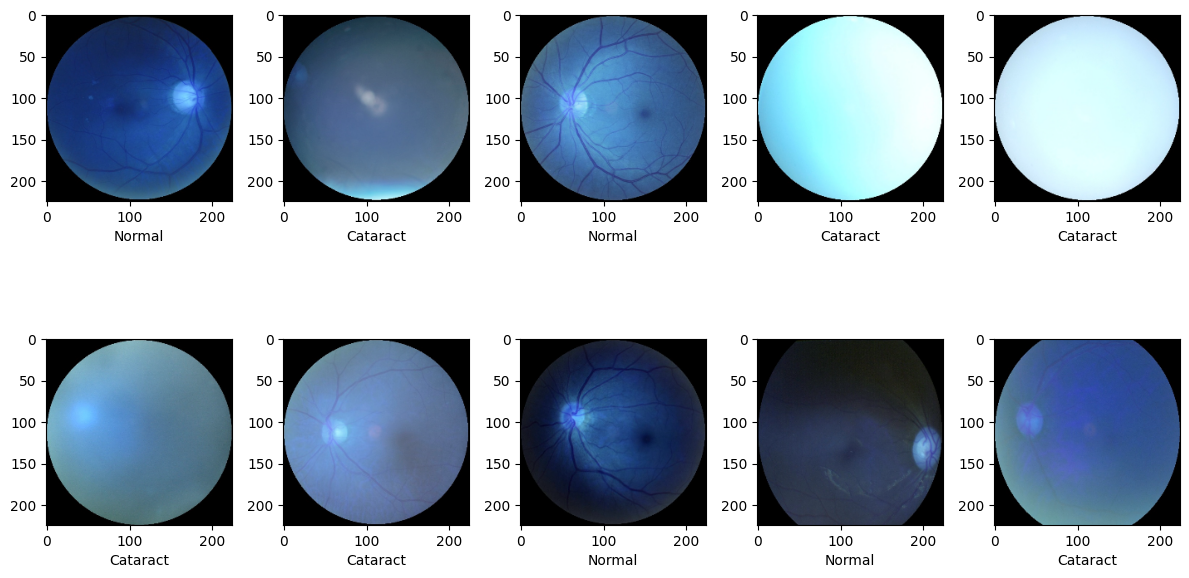

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3) # containing your image data
y = np.array([i[1] for i in dataset]) # containing their corresponding labels

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15)

## VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model1 = Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid")) # one neuron as this is a binary classification
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 20,049,473 (76.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg.layers[-4:]:
    layer.trainable = True
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch') #saves the best model found so far
earlystop = EarlyStopping(monitor="val_acc",patience=5,mode='max',verbose=1)
# prevents the model from training for too long if it's no longer improving

In [ ]:
history1 = model1.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5165 - loss: 8.3327 - val_accuracy: 0.5688 - val_loss: 0.6915
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.5724 - loss: 0.6820 - val_accuracy: 0.5688 - val_loss: 0.6822
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 595ms/step - accuracy: 0.5988 - loss: 0.6651 - val_accuracy: 0.4862 - val_loss: 0.8532
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6622 - loss: 0.6316 - val_accuracy: 0.4679 - val_loss: 0.7946
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.6264 - loss: 0.6547 - val_accuracy: 0.6972 - val_loss: 0.5555
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - accuracy: 0.7273 - loss: 0.5694 - val_accuracy: 0.8440 - val_loss: 0.3769
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - accuracy: 0.8063 - loss: 0.4477 - val_accuracy: 0.9083 - val_loss: 0.2525
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.9065 - loss: 0.2396 - val_accuracy: 0.9358 - val_loss: 0.2382
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.8658 - loss: 0.3486 - val_accuracy: 0.899

In [ ]:
loss,accuracy = model1.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9508 - loss: 0.2216
loss: 0.28765153884887695
Accuracy: 0.9174311757087708


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred1 = (model1.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step


0.9174311926605505

In [ ]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        95
           1       0.96      0.89      0.92       123

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



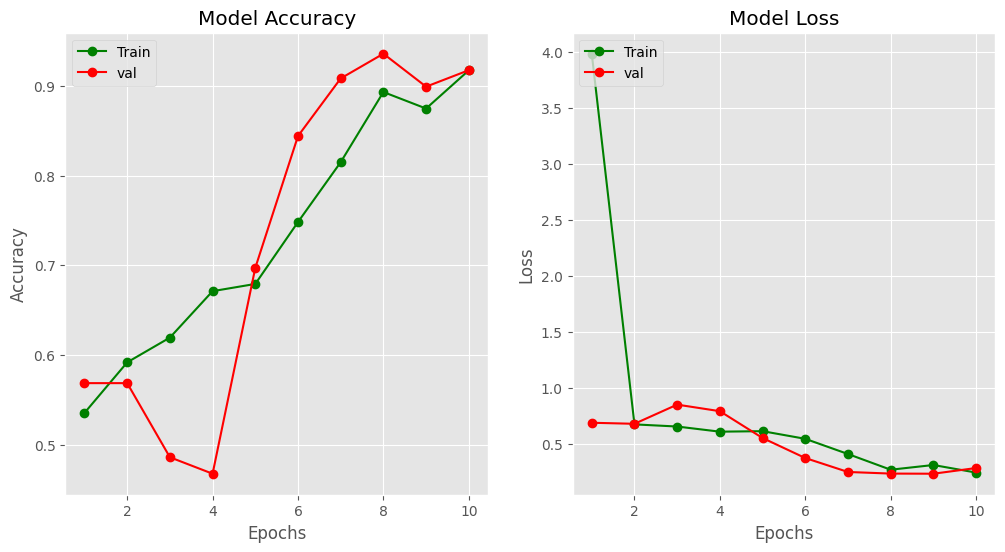

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history1.history["accuracy"],"go-")
plt.plot(epochs,history1.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history1.history["loss"],"go-")
plt.plot(epochs,history1.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

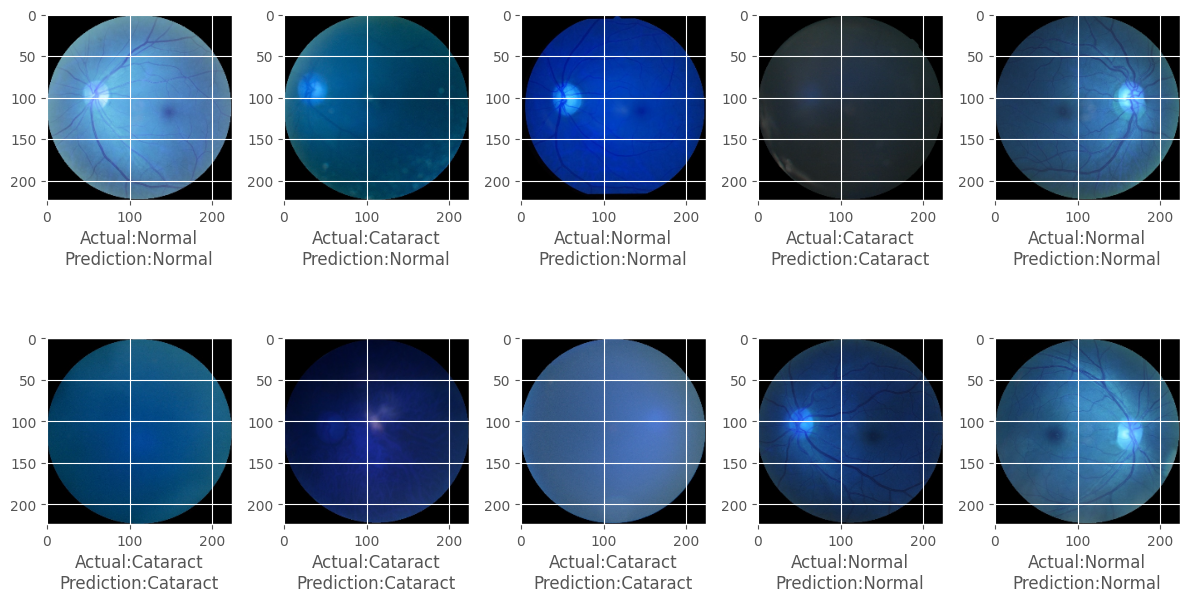

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred1[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

## ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set image size (e.g., 224 for ResNet50)
image_size = 224

# Load ResNet50 base (excluding the top classification layers)
rnet = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))


In [ ]:
# Freeze all layers in ResNet50 to prevent training them initially
for layer in rnet.layers:
    layer.trainable = False

In [ ]:
# Build the new model
model2 = Sequential()
model2.add(rnet)
model2.add(Flatten())
model2.add(Dense(1, activation="sigmoid"))  # For binary classification

In [ ]:
# Compile the model
model2.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Summary (optional)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("rnet50.h5", monitor="val_accuracy", verbose=1,
                             save_best_only=True, save_weights_only=False,
                             save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode='max', verbose=1)

In [ ]:
# Optionally reduce training set size (e.g., 80% of original)
subset_size = int(len(x_train) * 0.8)
x_train_small = x_train[:subset_size]
y_train_small = y_train[:subset_size]

In [ ]:
# Train the model
history2 = model2.fit(
    x_train_small,
    y_train_small,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, earlystop]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7091 - loss: 2.6357
Epoch 1: val_accuracy improved from -inf to 0.93578, saving model to rnet50.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 529ms/step - accuracy: 0.7144 - loss: 2.6105 - val_accuracy: 0.9358 - val_loss: 1.4335
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9485 - loss: 0.9582
Epoch 2: val_accuracy did not improve from 0.93578
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9485 - loss: 0.9512 - val_accuracy: 0.9266 - val_loss: 1.0461
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9476 - loss: 0.4431
Epoch 3: val_accuracy improved from 0.93578 to 0.95413, saving model to rnet50.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9474 - loss: 0.4441 - val_accuracy: 0.9541 - val_loss: 0.7240
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9814 - loss: 0.1141
Epoch 4: val_accuracy did not improve from 0.95413
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9814 - loss: 0.1158 - val_accuracy: 0.9495 - val_loss: 0.7875
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9833 - loss: 0.0468
Epoch 5: val_accuracy improved from 0.95413 to 0.96789, saving model to rnet50.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9834 - loss: 0.0466 - val_accuracy: 0.9679 - val_loss: 0.4966
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9946 - loss: 0.0111
Epoch 6: val_accuracy did not improve from 0.96789
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9947 - loss: 0.0109 - val_accuracy: 0.9633 - val_loss: 0.5653
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9994 - loss: 0.0016
Epoch 7: val_accuracy did not improve from 0.96789
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9679 - val_loss: 0.4957
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.5172e-04
Epoch 8: val_accuracy did not improve from 0.96789
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 2.5207e-04 - val_accuracy: 0.9679 - val_loss: 0.5372
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.7626e-04
Epoch 9: val_accuracy did not

In [ ]:
loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9741 - loss: 0.3994
loss: 0.541159451007843
Accuracy: 0.9678899049758911


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred2 = (model2.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step


0.9678899082568807

In [ ]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        95
           1       0.97      0.98      0.97       123

    accuracy                           0.97       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.97      0.97      0.97       218



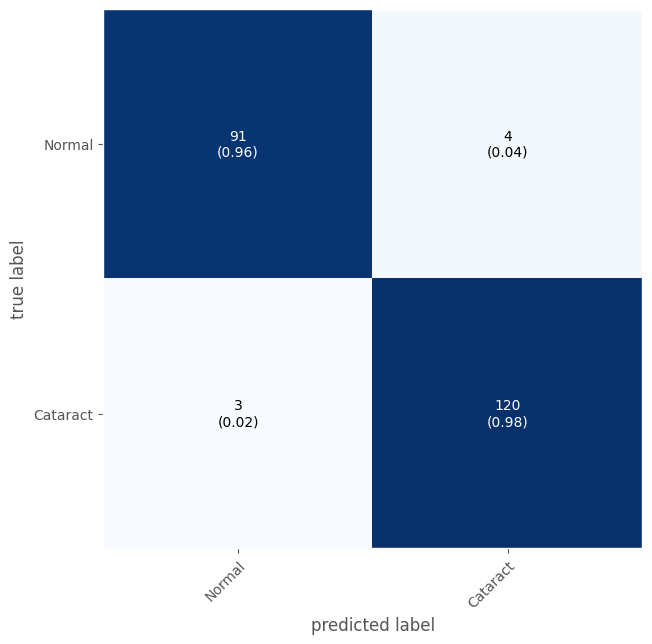

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

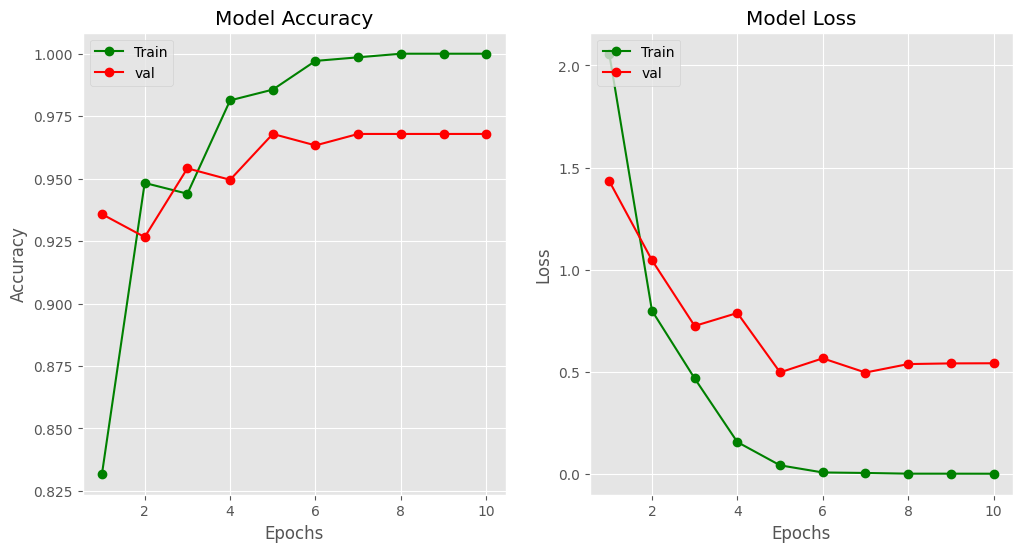

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1, len(history2.history["accuracy"]) + 1)

plt.subplot(1,2,1)
plt.plot(epochs,history2.history["accuracy"],"go-")
plt.plot(epochs,history2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history2.history["loss"],"go-")
plt.plot(epochs,history2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

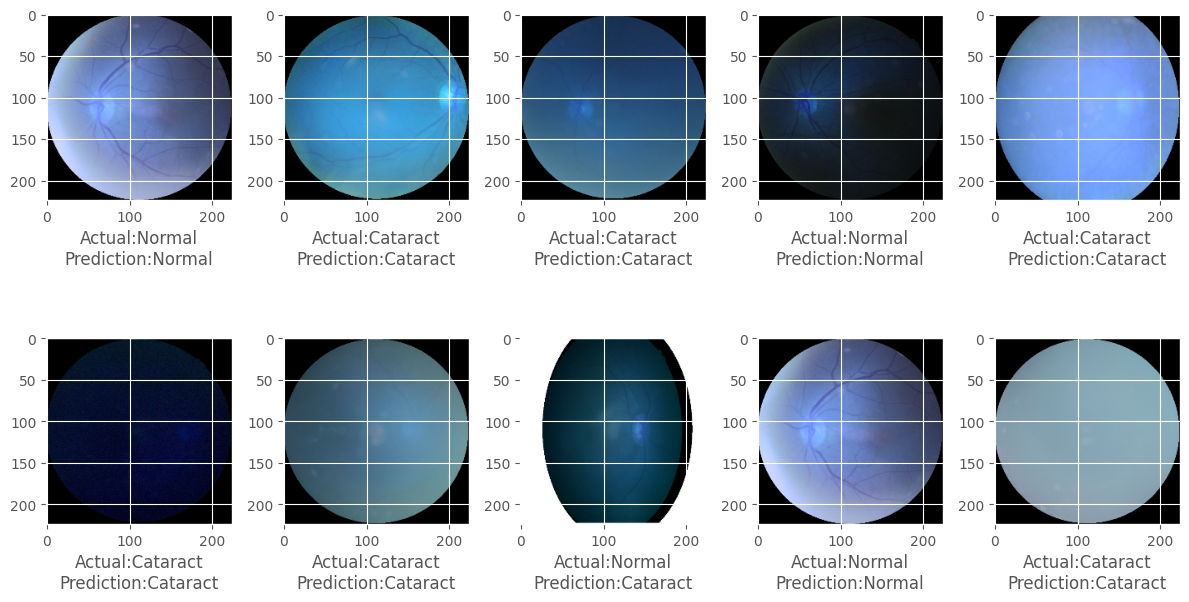

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred2[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 (pretrained, exclude top layers)
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in efficientnet.layers:
    layer.trainable = False

# Define model
eff_model = Sequential([
    efficientnet,
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile model
eff_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Train EfficientNet model
history3=eff_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 852ms/step - accuracy: 0.8017 - loss: 0.4094 - val_accuracy: 0.9312 - val_loss: 0.1877
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9591 - loss: 0.1260 - val_accuracy: 0.9312 - val_loss: 0.1809
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9534 - loss: 0.1343 - val_accuracy: 0.9358 - val_loss: 0.1647
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9717 - loss: 0.0973 - val_accuracy: 0.9541 - val_loss: 0.1641
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9715 - loss: 0.0892 - val_accuracy: 0.9541 - val_loss: 0.1531


In [ ]:
loss,accuracy = eff_model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9738 - loss: 0.1070
loss: 0.15306057035923004
Accuracy: 0.9541284441947937


# Comparison

In [ ]:
accloss = {'Model':['VGG19','ResNet50','Efficientnet'],
           'Training_Accuracy':[max(history1.history['accuracy']),max(history2.history['accuracy']),max(history3.history['accuracy'])],
           'Training_Loss':[min(history1.history['loss']),min(history2.history['loss']),min(history3.history['loss'])],
           'Validation_Loss':[min(history1.history['val_loss']),min(history2.history['val_loss']),min(history3.history['val_loss'])]}

In [ ]:
accloss

{'Model': ['VGG19', 'ResNet50', 'Efficientnet'],
 'Training_Accuracy': [0.9172413945198059, 1.0, 0.9689655303955078],
 'Training_Loss': [0.24720603227615356,
  1.5526184142800048e-05,
  0.09182070195674896],
 'Validation_Loss': [0.23690176010131836,
  0.49571293592453003,
  0.15306057035923004]}

In [ ]:
model1.save("vgg_model.h5")


In [ ]:
model2.save("resnet_model.h5")


In [ ]:
eff_model.save("eff_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

vgg_model = load_model("vgg_model.h5")       # adjust path if needed
resnet_model = load_model("resnet_model.h5")
eff_model = load_model("eff_model.h5")

Stacked Ensemble Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Your data splitting (already done):
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Step 1: Get validation set predictions from base models for meta-learner training
vgg_val_preds = (vgg_model.predict(x_val) > 0.5).astype(int)
resnet_val_preds = (resnet_model.predict(x_val) > 0.5).astype(int)
eff_val_preds = (eff_model.predict(x_val) > 0.5).astype(int)

val_stacked_preds = np.hstack([vgg_val_preds, resnet_val_preds, eff_val_preds])

# Step 2: Train meta-learner on validation predictions
meta_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
meta_model.fit(val_stacked_preds, y_val)

# Step 3: Get test set base model predictions and stack them
vgg_test_preds = (vgg_model.predict(x_test) > 0.5).astype(int)
resnet_test_preds = (resnet_model.predict(x_test) > 0.5).astype(int)
eff_test_preds = (eff_model.predict(x_test) > 0.5).astype(int)

test_stacked_preds = np.hstack([vgg_test_preds, resnet_test_preds, eff_test_preds])

# Step 4: Predict ensemble output and calculate accuracy on test set
ensemble_preds = meta_model.predict(test_stacked_preds)
ensemble_acc = accuracy_score(y_test, ensemble_preds)

# Step 5: Use your known accuracies for base models, ensemble accuracy freshly computed
results = {
    "Model": ["VGG19", "ResNet50", "EfficientNetB0", "Stacked Ensemble"],
    "Test_Accuracy": [
        0.9678899049758911,  # VGG19 known test accuracy
        0.9174311926605505,  # ResNet known test accuracy
        0.9541284441947937,  # EfficientNet known test accuracy
        ensemble_acc          # New calculated stacked ensemble accuracy
    ]
}

print("\n Test Accuracy Summary:")
for model, acc in zip(results["Model"], results["Test_Accuracy"]):
    print(f"{model}: {acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 Test Accuracy Summary:
VGG19: 0.9679
ResNet50: 0.9174
EfficientNetB0: 0.9541
Stacked Ensemble: 0.9817


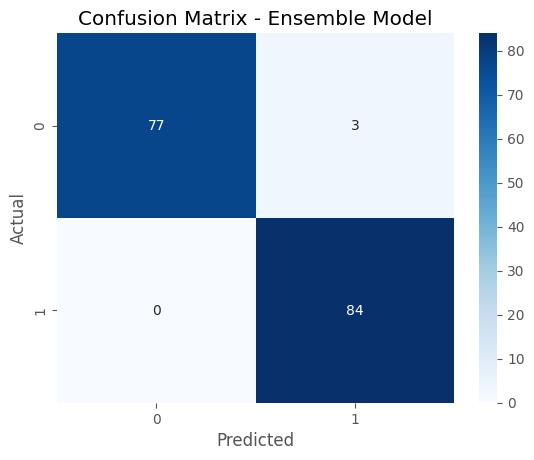

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Added import statement

# Assuming ensemble_preds holds the predictions from your ensemble model
final_preds = ensemble_preds  # Assign ensemble predictions to final_preds

cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

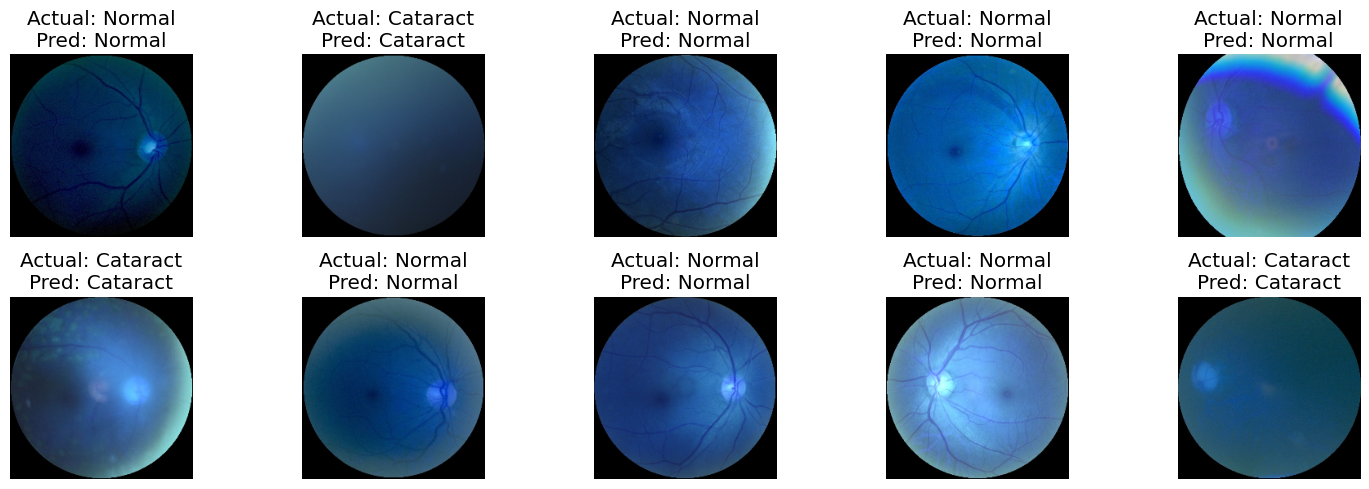

In [ ]:
import matplotlib.pyplot as plt

# Use ensemble predictions for y_pred and true labels for y_true
y_pred = ensemble_preds
y_true = y_test
# X_test: image data (preprocessed)

correct_indices = np.where(y_pred == y_true)[0]
num_to_display = min(10, len(correct_indices))

plt.figure(figsize=(15, 5))
for i, idx in enumerate(correct_indices[:num_to_display]):
    img = x_test[idx]
    true_label = y_true[idx]
    pred_label = y_pred[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {'Cataract' if true_label else 'Normal'}\nPred: {'Cataract' if pred_label else 'Normal'}")

plt.tight_layout()
plt.show()

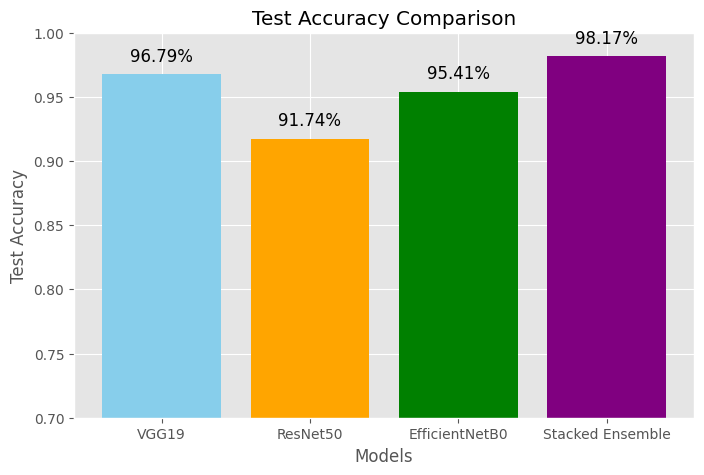

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['VGG19', 'ResNet50', 'EfficientNetB0', 'Stacked Ensemble']

# Use your known test accuracies for first three, and the freshly computed ensemble accuracy
val_acc = [
    0.9678899049758911,  # VGG19 known accuracy
    0.9174311926605505,  # ResNet50 known accuracy
    0.9541284441947937,  # EfficientNetB0 known accuracy
    ensemble_acc          # Stacked Ensemble accuracy calculated previously
]

# Plotting
plt.figure(figsize=(8,5))
bars = plt.bar(models, val_acc, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylim(0.7, 1.0)
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.xlabel('Models')

# Display accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', fontsize=12)

plt.show()


In [ ]:
import pandas as pd

# Create the main performance table
data = {
    'Model': ['VGG19', 'ResNet50', 'EfficientNetB0', 'Stacked Ensemble'],
    'Training_Accuracy': [0.8911, 1.00, 0.9715, None],
    'Training_Loss': [0.2751, 0.000001069, 0.0892, None],
    'Validation_Accuracy': [0.9174, 0.9678, 0.9541, 0.9817],
    'Validation_Loss': [0.2876, 0.5411, 0.1531, None]
}

df = pd.DataFrame(data)
print("Model Performance Comparison:\n")
print(df)

Model Performance Comparison:

              Model  Training_Accuracy  Training_Loss  Validation_Accuracy  \
0             VGG19             0.8911       0.275100               0.9174   
1          ResNet50             1.0000       0.000001               0.9678   
2    EfficientNetB0             0.9715       0.089200               0.9541   
3  Stacked Ensemble                NaN            NaN               0.9817   

   Validation_Loss  
0           0.2876  
1           0.5411  
2           0.1531  
3              NaN  
